# Tutorial on Using PDEs and PINNs for Predicting Chlorophyll Concentration

In this tutorial, we will explore how to use Partial Differential Equations (PDEs) and Physics-Informed Neural Networks (PINNs) to predict chlorophyll concentration from environmental data. We will cover the following sections:
- **Data Loading and Preprocessing**: How to load and preprocess environmental data.
- **Defining the PDE**: Formulation of the PDE governing the system.
- **Setting Up the PINN**: Building and training a PINN model.
- **Evaluating the Model**: Visualizing results and predictions.

Let's get started!

In [1]:
# Import necessary libraries
import os
os.environ["DDEBACKEND"] = "pytorch"

import deepxde as dde
import numpy as np
import torch
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

# Load and preprocess data function
def load_and_preprocess_data():
    print("Starting data load and preprocessing...")
    zarr_ds = xr.open_zarr(store='../shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)
    zarr_new = zarr_ds.sel(lat=slice(35, -5), lon=slice(45, 90), time=slice('2018-04-01', '2022-04-08'))
    all_nan_dates = np.isnan(zarr_new["CHL"]).all(dim=["lon", "lat"]).compute()
    zarr_ds = zarr_new.sel(time=all_nan_dates == False)
    
    return zarr_ds

# Data loading and preprocessing
zarr_ds = load_and_preprocess_data()
original_chl = zarr_ds['CHL'].values[-1]

# Prepare data function
def prepare_data_for_pinn(zarr_ds):
    print("Starting data preparation for PINN...")
    variables = ['CHL', 'air_temp', 'sst', 'curr_dir', 'ug_curr', 'u_wind', 'v_wind', 'v_curr']
    data = {var: zarr_ds[var].values for var in variables}
    
    # Water mask to filter out land areas
    water_mask = ~np.isnan(data['sst'][0])
    
    for var in variables:
        data[var] = data[var][:, water_mask]
        data[var] = np.nan_to_num(data[var], nan=np.nanmean(data[var]), posinf=np.nanmax(data[var]), neginf=np.nanmin(data[var]))
        mean = np.mean(data[var])
        std = np.std(data[var])
        data[var] = (data[var] - mean) / std
        data[f'{var}_mean'] = mean
        data[f'{var}_std'] = std

    time = zarr_ds.time.values
    lat = zarr_ds.lat.values
    lon = zarr_ds.lon.values
    time_numeric = (time - time[0]).astype('timedelta64[D]').astype(float)
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    lat_flat = lat_grid.flatten()[water_mask.flatten()]
    lon_flat = lon_grid.flatten()[water_mask.flatten()]
    
    return data, time_numeric, lat_flat, lon_flat, water_mask

# Prepare data
data, time, lat, lon, water_mask = prepare_data_for_pinn(zarr_ds)


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Starting data load and preprocessing...
Starting data preparation for PINN...


## Defining the PDE

In this section, we define the Partial Differential Equation (PDE) governing the chlorophyll concentration. The PDE we use models the diffusion and advection of chlorophyll in the ocean based on various environmental factors.

The general form of the PDE is:

$$ 
\frac{\partial U}{\partial t} = \alpha \nabla^2 U + \beta (\text{environmental factors}) 
$$

where:
- $U$ is the chlorophyll concentration,
- $\nabla^2$ is the Laplacian operator (representing diffusion),
- Environmental factors include air temperature, sea surface temperature, current direction, and wind speed.

The specific PDE used in our model is:

$$
\frac{\partial U}{\partial t} = \frac{\partial^2 U}{\partial \text{lat}^2} + \frac{\partial^2 U}{\partial \text{lon}^2} - \rho(t, \text{lat}, \text{lon})
$$

where $\rho(t, \text{lat}, \text{lon})$ is a function of time, latitude, and longitude that incorporates the effects of environmental factors.

Let's define this PDE in our code.

In [44]:
# Define the PDE
def pde(x, y):
    lat, lon, t = x[:, 0:1], x[:, 1:2], x[:, 2:3]
    U = y[:, 0:1]
    dU_dt = dde.grad.jacobian(y, x, i=0, j=2)
    d2U_dlat2 = dde.grad.hessian(y, x, component=0, i=0, j=0)
    d2U_dlon2 = dde.grad.hessian(y, x, component=0, i=1, j=1)
    d2U_dt2 = dde.grad.hessian(y, x, component=0, i=2, j=2)
    
    # Environmental factors
    air_temp = y[:, 1:2]
    sst = y[:, 2:3]
    curr_dir = y[:, 3:4]
    ug_curr = y[:, 4:5]
    u_wind = y[:, 5:6]
    v_wind = y[:, 6:7]
    v_curr = y[:, 7:8]
    
    # Define the source term rho
    rho = 0.1 * torch.sin(lat) * torch.cos(lon)+ \
          0.05 * torch.sin(2 * np.pi * t / 365) + \
         (0.5 * air_temp + 
           -1.0 * sst + 
           0.05 * curr_dir + 
           0.15 * ug_curr + 
           0.4 * u_wind + 
           -0.2 * v_wind + 
           0.3 * v_curr)
    
    residual = d2U_dlat2 + d2U_dlon2 + d2U_dt2 - rho
    return residual


## Setting Up the PINN

We now set up the PINN (Physics-Informed Neural Network) for training. The PINN leverages both the physical PDE and data to learn the solution. This approach is beneficial compared to traditional Deep Neural Networks (DNNs) because it integrates physical laws into the training process, improving the model's generalization and reducing overfitting.

### Spatial and Temporal Domains

We need to define the spatial and temporal domains for our problem. In this case, our spatial domain is a rectangle defined by latitude and longitude, and the temporal domain is a time interval.

Let's set up these domains.

In [45]:
# Get boundaries for the mask
lat_min, lat_max = lat.min(), lat.max()
lon_min, lon_max = lon.min(), lon.max()
time_min, time_max = time.min(), time.max()

spatial_domain = dde.geometry.Rectangle(xmin=[lat_min, lon_min], xmax=[lat_max, lon_max])
temporal_domain = dde.geometry.TimeDomain(t0=time_min, t1=time_max)
geomtime = dde.geometry.GeometryXTime(spatial_domain, temporal_domain)

# Use cartopy to define coastlines
coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m')

# Create a function to check if a point is in the ocean
def is_in_ocean(lat, lon):
    point = Point(lon, lat)
    for geometry in coastline.geometries():
        if geometry.contains(point):
            return False
    return True

# Modify the boundary condition function
def boundary_condition(x, on_boundary):
    lat = x[0]
    lon = x[1]
    ocean_boundary = is_in_ocean(lat, lon)
    return on_boundary and ocean_boundary


### Boundary Conditions

Boundary conditions are crucial for solving PDEs. In this case, we use Robin boundary conditions, which are a combination of Dirichlet and Neumann conditions. They are suitable for problems where a combination of known values and fluxes is applied at the boundaries.

The Robin boundary condition is given by:

$$
a U + b \frac{\partial U}{\partial n} = g 
$$

where $a$ and $b$ are coefficients, and $g$ is the source term.

Let's define the boundary condition function.

In [46]:
# Define the Robin boundary condition function
def robin_bc_func(x, y, grad_y):
    a = 1.0  # Coefficient for the value term
    b = 1.0  # Coefficient for the gradient term
    g = 0.0  # Source term
    return a * y + b * grad_y - g

# Define the boundary condition
bc_robin = dde.icbc.RobinBC(geomtime, robin_bc_func, boundary_condition)


### Training the PINN

We are now ready to set up the PINN model. We use the DeepONet architecture for this task. This neural network architecture is particularly effective for problems with complex boundary conditions and varying spatial-temporal features.

Let's define and train the PINN model.

In [47]:
# Data for PINN
data_pinn = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_robin],
    num_domain=10000,
    num_boundary=2000,
    num_initial=2000,
)

# Neural network model using DeepONet
layer_sizes_branch = [8, 64, 64, 64]
layer_sizes_trunk = [3, 64, 64, 64]
activation = "tanh"
net = dde.nn.pytorch.DeepONet(layer_sizes_branch, layer_sizes_trunk, activation, "Glorot normal")

model = dde.Model(data_pinn, net)

model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=10000)

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(losshistory.steps, losshistory.loss_train, label="Training Loss")
plt.plot(losshistory.steps, losshistory.loss_test, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()
plt.show()


Compiling model...
'compile' took 0.000144 s



NameError: name 'losshistory' is not defined

<Figure size 1000x600 with 0 Axes>

### Evaluating and Visualizing Results

After training, we can use the PINN model to predict chlorophyll concentrations. We will compare the predicted concentrations with the original values to evaluate the model's performance.

Let's visualize the results.

In [42]:
# Prediction function
def predict(x):
    output = model.predict(x)
    chl_normalized = output[:, 0]
    chl = chl_normalized * data['CHL_std'] + data['CHL_mean']
    return chl

prediction_time = np.full_like(lat, time_max)
x_pred = np.stack([lat, lon, prediction_time], axis=-1)
chl_pred = predict(x_pred)

chl_pred_grid = np.full(water_mask.shape, np.nan)
chl_pred_grid[water_mask] = chl_pred.flatten()

print("Prediction complete.")

# Visualization function for map
def plot_map(data, title, cmap='viridis', vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    im = ax.pcolormesh(zarr_ds.lon, zarr_ds.lat, data, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax)
    
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    
    ax.gridlines(draw_labels=True)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
    plt.colorbar(im, cax=cax)
    
    plt.title(title)
    
    return fig, ax

# Visualizations
original_chl = zarr_ds['CHL'].values[-1]

# Plot original chlorophyll concentration
fig, ax = plot_map(original_chl, "Original Chlorophyll Concentration")
plt.show()

# Plot predicted chlorophyll concentration
fig, ax = plot_map(chl_pred_grid, "Predicted Chlorophyll Concentration")
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x3 and 8x64)

In [41]:
original_chl = zarr_ds['CHL'].values[-1]
chl_pred_grid = zarr_ds['CHL'].values[-5]
# Plot original chlorophyll concentration
fig, ax = plot_map(original_chl, "Original Chlorophyll Concentration")
plt.show()

# Plot predicted chlorophyll concentration
fig, ax = plot_map(chl_pred_grid, "Predicted Chlorophyll Concentration")
plt.show()


NameError: name 'plot_map' is not defined

## Conclusion

In this tutorial, we demonstrated how to use PDEs and PINNs to predict chlorophyll concentration based on environmental data. We walked through the process of:
- **Loading and Preprocessing Data**: Preparing the data for input into the PINN model.
- **Defining the PDE**: Formulating the PDE governing the chlorophyll concentration.
- **Setting Up the PINN**: Creating and training the PINN model with physical constraints.
- **Evaluating the Model**: Comparing predictions with actual data and visualizing results.

This approach benefits from incorporating physical laws into the learning process, enhancing the model's reliability and interpretability.

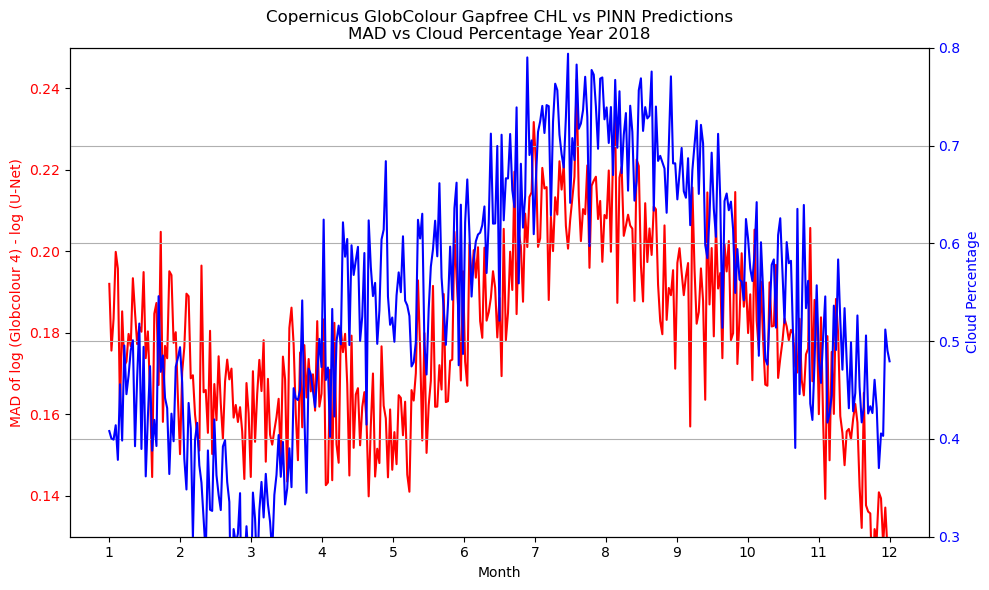